In [ ]:
!pip install num2words
!pip install emoji

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 8.8 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=a070b1868f19fdbda7dff78f409ce06846025b937bb9946e09271706b1aef263
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built docopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 15.0 MB/s eta 0:00:00


In [ ]:
import re, random
import numpy as np
import nltk
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
from num2words import num2words
import emoji

nltk.download('stopwords')
# MODEL_NAME = "aubmindlab/bert-base-arabertv2"
# MODEL_NAME = "bert-base-multilingual-cased"
MODEL_NAME = "xlm-roberta-base"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)



--- RUNNING HYPOTHESIS TEST 1: Untrained Embedding Analysis on Urdu ---
Loading Target Data (Urdu) for zero-shot check...
Loading raw xlm-roberta-base...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Extracting embeddings...
Calculating t-SNE...
Saved plot to 'hypothesis_urdu_untrained.png'
--- TEST 1 COMPLETE ---



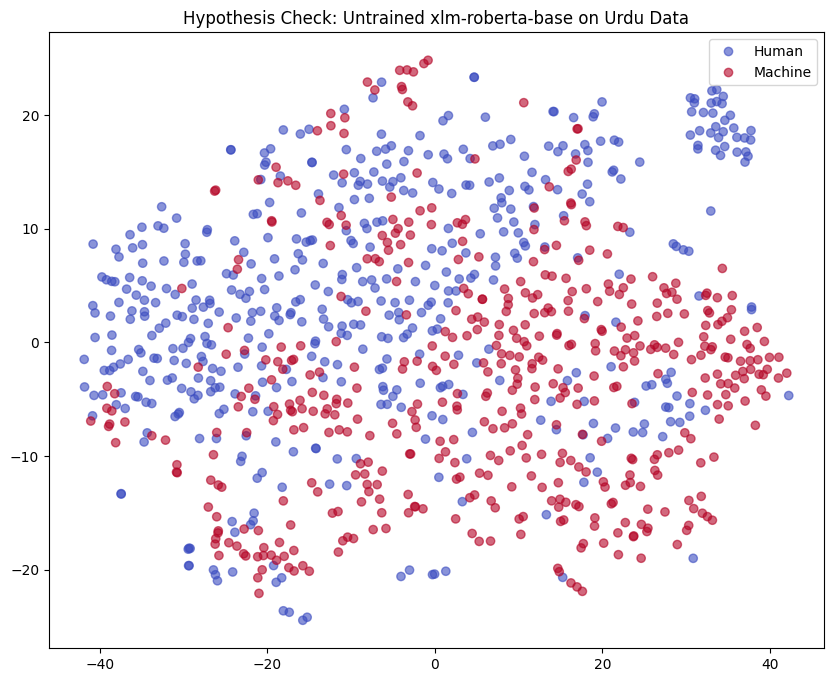

In [ ]:
# ==================================================================================
# HYPOTHESIS TEST 1: Zero-Shot Check on URDU (Target) - Before Training
# Purpose: Check if untrained XLM-R already separates Urdu Human/Machine text.
# ==================================================================================
print("\n--- RUNNING HYPOTHESIS TEST 1: Untrained Embedding Analysis on Urdu ---")

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the TARGET Data (Urdu)
# We define a temporary simple cleaner since the main one isn't defined yet
def temp_clean_urdu(text):
    text = str(text).strip()
    text = re.sub(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+', ' ', text)
    return text

print("Loading Target Data (Urdu) for zero-shot check...")
df_target = pd.read_csv('urdu_train.csv')
# Map labels if they are strings
if df_target['label'].dtype == object:
    df_target["label"] = df_target["label"].map({"human": 0, "machine": 1})

# Sample 500 from each class for the plot (to keep it readable)
df_h = df_target[df_target['label']==0].sample(n=500, random_state=42)
df_m = df_target[df_target['label']==1].sample(n=500, random_state=42)
df_viz = pd.concat([df_h, df_m]).reset_index(drop=True)

# 2. Load Raw Model
print(f"Loading raw {MODEL_NAME}...")
temp_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
temp_model = AutoModel.from_pretrained(MODEL_NAME).to(torch.device("cuda"))
temp_model.eval()

# 3. Extract Embeddings
print("Extracting embeddings...")
embeddings = []
labels_viz = df_viz['label'].tolist()
# Assuming the text column in urdu_train.csv is named 'text'
texts_viz = df_viz['text'].astype(str).apply(temp_clean_urdu).tolist()

batch_size_viz = 32
with torch.no_grad():
    for i in range(0, len(texts_viz), batch_size_viz):
        batch_txt = texts_viz[i:i+batch_size_viz]
        inputs = temp_tokenizer(batch_txt, return_tensors="pt", padding=True, truncation=True, max_length=128).to(torch.device("cuda"))
        outputs = temp_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

X_viz = np.vstack(embeddings)

# 4. t-SNE & Plot
print("Calculating t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_viz)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels_viz, cmap='coolwarm', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=['Human', 'Machine'])
plt.title(f"Hypothesis Check: Untrained {MODEL_NAME} on Urdu Data")
plt.savefig("hypothesis_urdu_untrained.png")
print("Saved plot to 'hypothesis_urdu_untrained.png'")
print("--- TEST 1 COMPLETE ---\n")

# Cleanup
del temp_model
del temp_tokenizer
torch.cuda.empty_cache()
# ==================================================================================

In [ ]:
df = pd.read_csv('ground_truth.csv')
df = df.drop(columns=['id'])

label_map = {"human": 0, "machine": 1}
df["label"] = df["label"].map(label_map)

stopwords_arabic = set(stopwords.words('arabic'))

# Arabic Text Cleaning Functions
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ة", "ه", text)
    return text

def remove_diacritics(text):
    arabic_diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u0670\u06D6-\u06ED]")
    return re.sub(arabic_diacritics, "", text)

def remove_tatweel(text):
    return re.sub(r'ـ+', '', text)

def remove_punctuation(text):
    arabic_punctuations = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~“”‘’،؛؟…«»"""
    return re.sub(f"[{re.escape(arabic_punctuations)}]", " ", text)

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

def remove_emojis(text):
    return emoji.replace_emoji(text, replace="")

def remove_urls_handles(text):
    pattern = re.compile(r'@\w+|https?://\S+|www\.\S+|#\w+|\S+@\S+|\d+')
    return pattern.sub(" ", text)

def numbers_to_arabic_words(text):
    def replace(match):
        num = int(match.group())
        return num2words(num, lang='ar')
    return re.sub(r'\d+', replace, text)


def clean_text(text):
    text = str(text).strip()

    text = remove_emojis(text)
    # text = numbers_to_arabic_words(text)
    text = remove_urls_handles(text)

    text = normalize_arabic(text)
    # text = remove_diacritics(text)
    text = remove_tatweel(text)
    # text = remove_punctuation(text)

    text = normalize_whitespace(text)
    return text



cleaned_texts = df["content"].astype(str).apply(clean_text).tolist()
labels = torch.tensor(df['label'].values, dtype=torch.long)

# Tokenization
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encodings = tokenizer(cleaned_texts, padding=True, truncation=True, max_length=128)

In [ ]:
# Dataset
class ArabicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

dataset = ArabicDataset(encodings, labels)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
class BertClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

model = BertClassifier().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

criterion = nn.CrossEntropyLoss()

for epoch in range(3):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == batch_labels).sum().item()
        train_total += batch_labels.size(0)

    train_acc = train_correct / train_total

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")


/tmp/ipython-input-2229955769.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch 1 | Train Loss: 61.5420 | Train Acc: 0.8096
Epoch 2 | Train Loss: 14.4146 | Train Acc: 0.9719
Epoch 3 | Train Loss: 6.4022 | Train Acc: 0.9874


In [ ]:
# Testing on a different dataset

In [ ]:
class InferenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=max_length
        )
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item


In [ ]:
df = pd.read_parquet("by_polishing-00000-of-00001.parquet")

human_col = 'original_abstract'
ai_cols = [
    'allam_generated_abstract',
    'jais_generated_abstract',
    'llama_generated_abstract',
    'openai_generated_abstract'
]

def make_df(col, df, label):
    out = df[[col]].rename(columns={col: "text"})
    out["label"] = label
    return out

df_human = make_df(human_col, df, 0)
df_ai = make_df(ai_cols[0], df, 1)

df_test = pd.concat([df_human[:1000], df_ai[:1000]], ignore_index=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)
df_test["text"] = df_test["text"].astype(str).apply(clean_text)

test_dataset = InferenceDataset(
    texts=df_test["text"].tolist(),
    labels=df_test["label"].values,
    tokenizer=tokenizer
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        batch_preds = torch.argmax(outputs, dim=1)

        preds.extend(batch_preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(
    true_labels,
    preds,
    target_names=["human", "machine"],
    digits=3
))

print("Macro F1:", f1_score(true_labels, preds, average="macro"))

Classification Report:
              precision    recall  f1-score   support

       human      0.985     0.923     0.953      1000
     machine      0.928     0.986     0.956      1000

    accuracy                          0.955      2000
   macro avg      0.956     0.955     0.954      2000
weighted avg      0.956     0.955     0.954      2000

Macro F1: 0.9544548077830226


In [ ]:
test_urdu = pd.read_csv("urdu_train.csv")
test_urdu = test_urdu.sample(frac=1, random_state=42).reset_index(drop=True)

def clean_text(text):
    text = str(text).strip()
    text = remove_emojis(text)
    text = remove_urls_handles(text)
    # text = remove_punctuation(text)

    text = normalize_whitespace(text)
    return text

urdu_dataset = InferenceDataset(
    texts=test_urdu["text"].astype(str).apply(clean_text).tolist(),
    labels=test_urdu["label"].values,
    tokenizer=tokenizer
)

urdu_loader = DataLoader(
    urdu_dataset,
    batch_size=32,
    shuffle=False
)

model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in urdu_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        batch_preds = torch.argmax(outputs, dim=1)

        preds.extend(batch_preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(
    true_labels,
    preds,
    target_names=["human", "machine"],
    digits=3
))

print("Macro F1:", f1_score(true_labels, preds, average="macro"))

Classification Report:
              precision    recall  f1-score   support

       human      0.667     0.486     0.562      5955
     machine      0.596     0.757     0.667      5955

    accuracy                          0.621     11910
   macro avg      0.631     0.621     0.614     11910
weighted avg      0.631     0.621     0.614     11910

Macro F1: 0.6144312302151973



--- RUNNING HYPOTHESIS TEST 2: Arabic-Trained Model on Urdu ---
Loading Target Data (Urdu) for trained visualization...
Extracting embeddings from TRAINED model...
Calculating t-SNE...
Saved plot to 'hypothesis_urdu_TRAINED.png'
--- TEST 2 COMPLETE ---


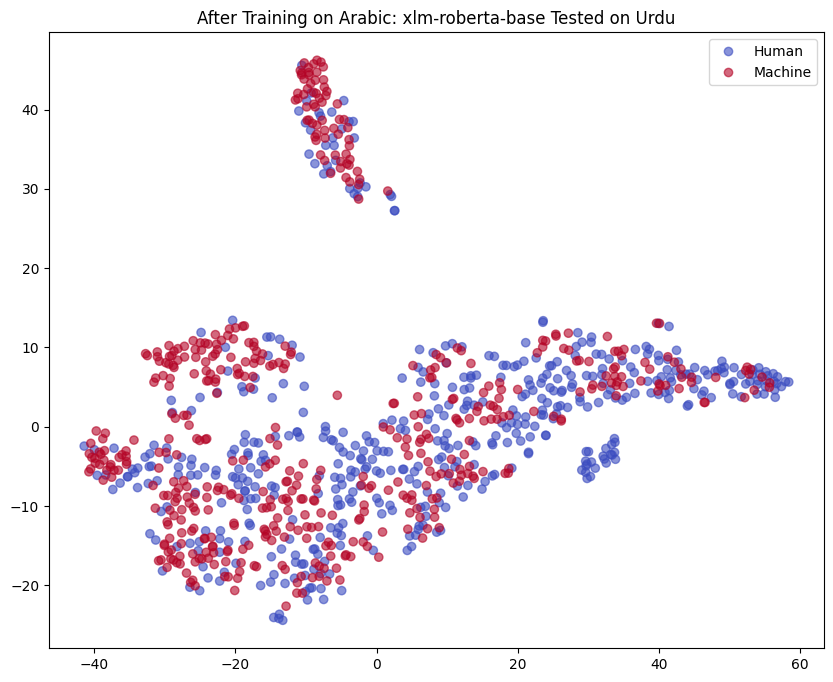

In [ ]:
# ==================================================================================
# HYPOTHESIS TEST 2: Trained Embedding Analysis on Urdu
# Purpose: Did learning Arabic help the model organize Urdu?
# ==================================================================================
print("\n--- RUNNING HYPOTHESIS TEST 2: Arabic-Trained Model on Urdu ---")

# 1. Re-load the Urdu Data
print("Loading Target Data (Urdu) for trained visualization...")
df_target_after = pd.read_csv('urdu_train.csv')
if df_target_after['label'].dtype == object:
    df_target_after["label"] = df_target_after["label"].map({"human": 0, "machine": 1})

# Sample 500
df_h = df_target_after[df_target_after['label']==0].sample(n=500, random_state=42)
df_m = df_target_after[df_target_after['label']==1].sample(n=500, random_state=42)
df_viz_after = pd.concat([df_h, df_m]).reset_index(drop=True)

# 2. Extract Embeddings using TRAINED model
print("Extracting embeddings from TRAINED model...")
embeddings_after = []
labels_after = df_viz_after['label'].tolist()
# Use the main 'clean_text' function from your script
texts_after = df_viz_after['text'].astype(str).apply(clean_text).tolist()

model.eval()

batch_size_viz = 32
with torch.no_grad():
    for i in range(0, len(texts_after), batch_size_viz):
        batch_txt = texts_after[i:i+batch_size_viz]
        inputs = tokenizer(batch_txt, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

        # Access .bert to get raw embeddings, ignoring the classifier head
        outputs = model.bert(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        embeddings_after.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

X_viz_after = np.vstack(embeddings_after)

# 3. t-SNE & Plot
print("Calculating t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
X_embedded_after = tsne.fit_transform(X_viz_after)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_embedded_after[:, 0], X_embedded_after[:, 1], c=labels_after, cmap='coolwarm', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=['Human', 'Machine'])
plt.title(f"After Training on Arabic: {MODEL_NAME} Tested on Urdu")
plt.savefig("hypothesis_urdu_TRAINED.png")
print("Saved plot to 'hypothesis_urdu_TRAINED.png'")
print("--- TEST 2 COMPLETE ---")

In [ ]:
# model -> 2 (bert multilingual)

In [ ]:
# removing punctuations

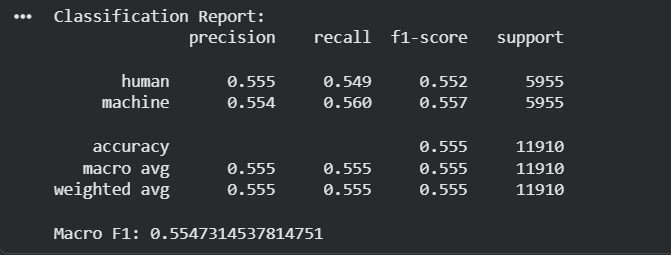

In [ ]:
# without removing punctuations from both datasets

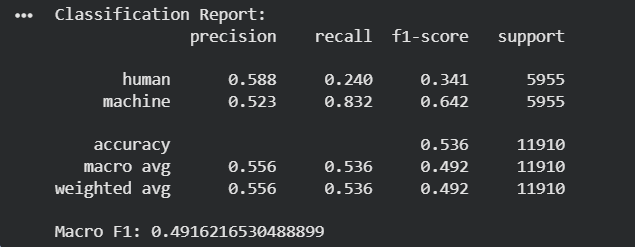

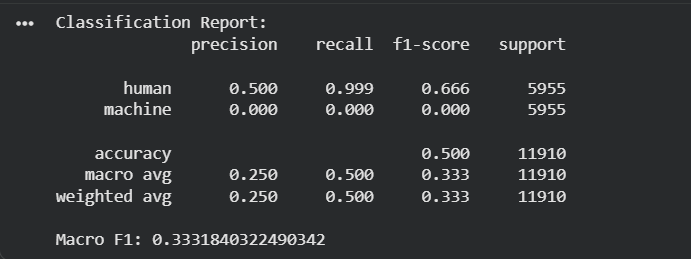